### Import

In [1]:
import heavysnow as hs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2 
%load_ext rpy2.ipython
%run pybase

### Data 

In [2]:
f=np.array([-1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1])*1.0
n=len(f)
V=list(range(n))
W=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        if abs(i-j)==1: W[i,j]=1
W[0,0]=1
W[n-1,n-1]=1

In [3]:
gs=hs.GraphSignal(V,W,f)

In [4]:
gs.initdist=np.array([1/n]*n)

### HST

In [5]:
hst=hs.HeavySnowTransform(gs)
hst.snow(tau=80000,b=0.03)

HST (tau= 80000, b=0.03)
80000/80000
HST completed and all history is recorded.


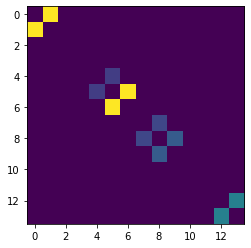

In [6]:
plt.imshow(hst.snowweight)

### 시각화를 위해서 R로 자료를 옮김

In [7]:
maxtau=hst.tau
W_Graph=hst.graphweight
W_Euclid=hst.euclidweight
W_HST=hst.snowweight
V=np.array(hst.V)
f=hst.f
n=hst.n
%R -i maxtau,W_Graph,W_Euclid,W_HST,V,f,n

### R을 활용한 시각화 (1): 원래자료 

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘gridExtra’


R[write to console]: The following object is masked from ‘package:dplyr’:

    combine


R[write to console]: 
Attaching package: ‘lubridate’


R[write to console]: The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




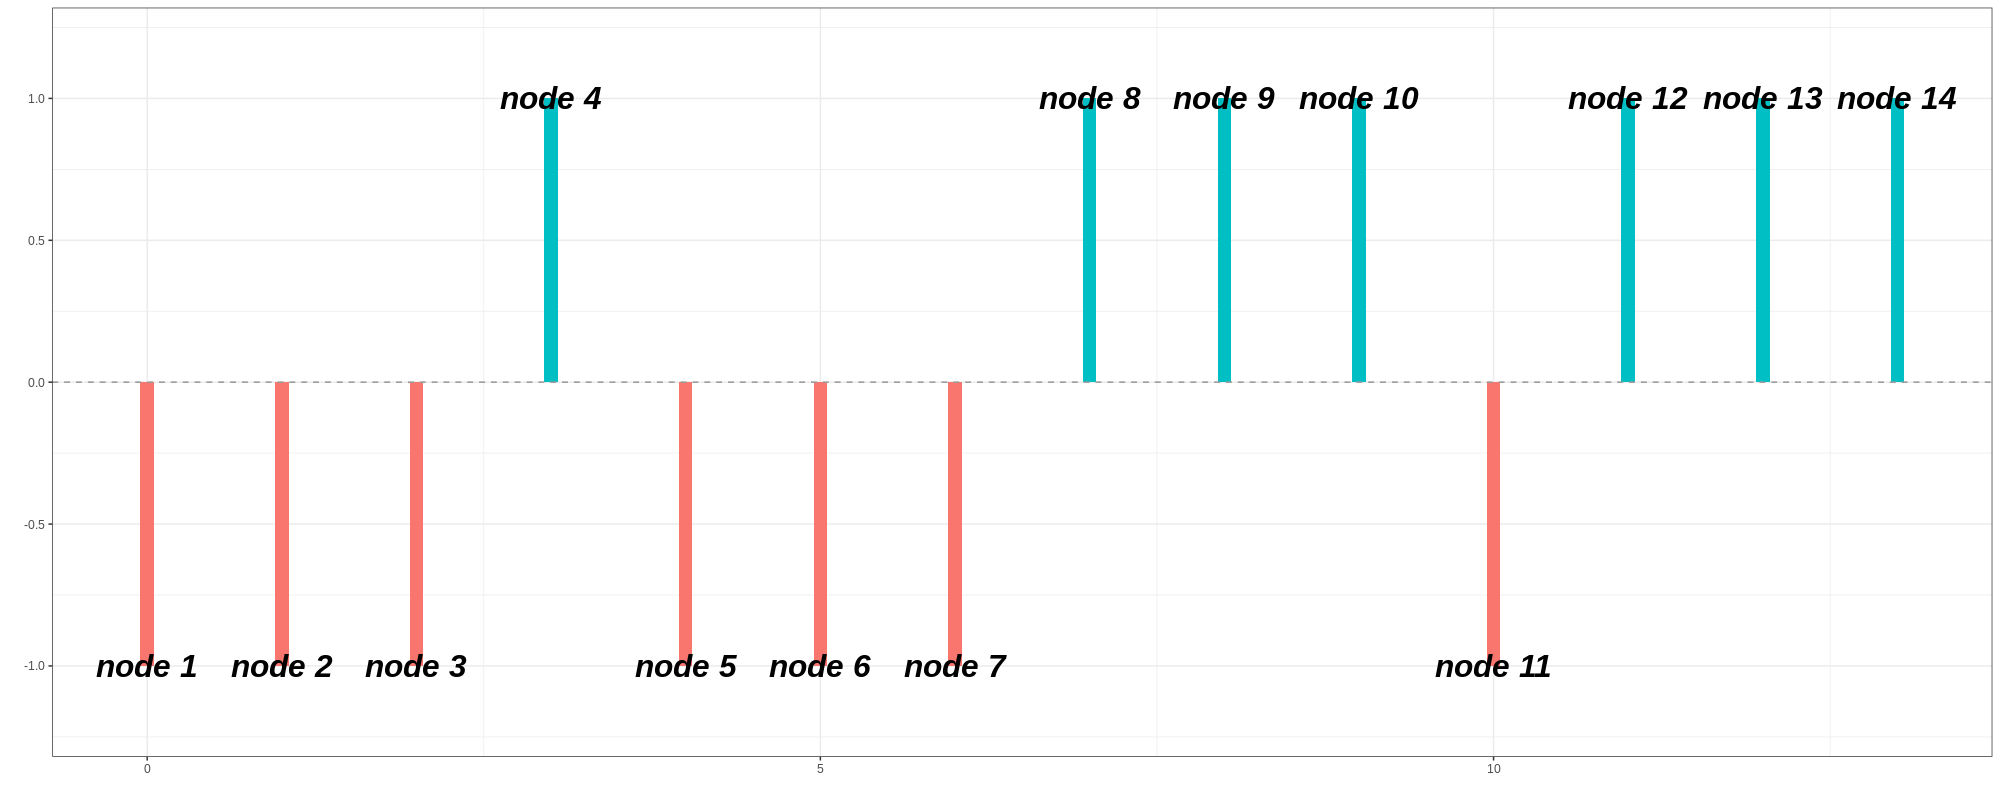

In [8]:
%%R -w 2000 -h 800 -r 100
library(tidyverse)
library(latex2exp)
library(gridExtra)
source('rbase.R')
Vtext=str_c('node ',V+1)
fig0<-ggplot(data=tibble(V=V,f=f,Vtext=Vtext),aes(x=V,y=f,label=Vtext))+
geom_col(aes(fill=(f>0)),width=0.1)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
geom_text(fontface = 4,size=8)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.2,1.2)+
theme(plot.title=element_text(face="bold.italic"))
#ggsave(plot=p0,"./fig/2021-0217_fig0.pdf",width=20,height=6)
fig0

### R을 활용한 시각화 (2): Weight matrix 와 Eigen plot 

`-` `ggplot`에서 `geom_tile`을 사용하기 위해서 매트릭스 형태인 `W_Graph`, `W_Euclid`, `W_HST`를 길게 펼친다. 결과를 각각 `W_Graph_long`, `W_Euclid_long`, `W_HST_long`에 저장한다. 

In [9]:
%%R
grid<-expand.grid(x=1:n,y=1:n)
W_Graph_long<-as_tibble(cbind(grid,as.vector(W_Graph)));names(W_Graph_long)<-c("x","y","W")
W_Euclid_long<-as_tibble(cbind(grid,as.vector(W_Euclid)));names(W_Euclid_long)<-c("x","y","W")
W_HST_long<-as_tibble(cbind(grid,as.vector(W_HST)));names(W_HST_long)<-c("x","y","W")

`-` 그래프퓨리에 변환: $(\bf{f},\bf{W})$에 그래프 퓨리에 변환을 수행함.  

In [10]:
%%R
source('heavysnow.R')
gfftrslt_Euclid<-gfft(f,W_Euclid)
gfftrslt_Graph<-gfft(f,W_Graph)
gfftrslt_HST<-gfft(f,W_HST)

R[write to console]: 
Attaching package: ‘kohonen’


R[write to console]: The following object is masked from ‘package:purrr’:

    map


R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:lubridate’:

    %--%, union


R[write to console]: The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


R[write to console]: The following objects are masked from ‘package:purrr’:

    compose, simplify


R[write to console]: The following object is masked from ‘package:tidyr’:

    crossing


R[write to console]: The following object is masked from ‘package:tibble’:

    as_data_frame


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




`-` 그래프 퓨리에 변환의 결과 고유치, 고유벡터, $\bf{\bar{f}}$가 반환됨. 

In [11]:
%%R
head(gfftrslt_HST)

$λ
 [1] 1.000001e+00 1.787345e-06 1.470615e-07 1.416525e-07 1.302853e-07
 [6] 1.388941e-08 2.177604e-11 3.320085e-12 1.973246e-14 1.533766e-16
[11] 1.384959e-18 5.606658e-26 3.974896e-26 1.761591e-30

$Ψ
               [,1]          [,2]          [,3]          [,4]          [,5]
 [1,] -1.403931e-22  7.070809e-01 -7.947551e-24  7.591779e-19  1.348505e-22
 [2,] -1.403863e-22 -7.071326e-01 -7.947164e-24  7.591420e-19  1.348439e-22
 [3,] -2.876394e-18  8.408882e-10 -1.628472e-19 -3.577911e-14  2.763119e-18
 [4,]  4.207339e-24  9.954128e-26 -6.214184e-16 -5.551115e-16 -2.371401e-17
 [5,]  2.829643e-05  2.304122e-22  4.996446e-18  1.773058e-01 -7.321149e-13
 [6,] -9.999996e-01 -4.428097e-23  9.268412e-22 -8.536656e-04  3.230721e-15
 [7,]  8.725068e-04 -3.411385e-24  9.002328e-19 -9.841554e-01  3.726534e-12
 [8,]  6.118374e-20  5.889401e-37  1.237469e-16  2.556936e-12  1.587786e-01
 [9,]  7.925032e-25 -5.915170e-39  5.273557e-17 -3.280217e-12 -9.333698e-01
[10,]  1.012965e-28  3.646515e-40  9

`-` 시각화코드 

TableGrob (2 x 3) "arrange": 6 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (2-2,1-1) arrange gtable[layout]
5 5 (2-2,2-2) arrange gtable[layout]
6 6 (2-2,3-3) arrange gtable[layout]


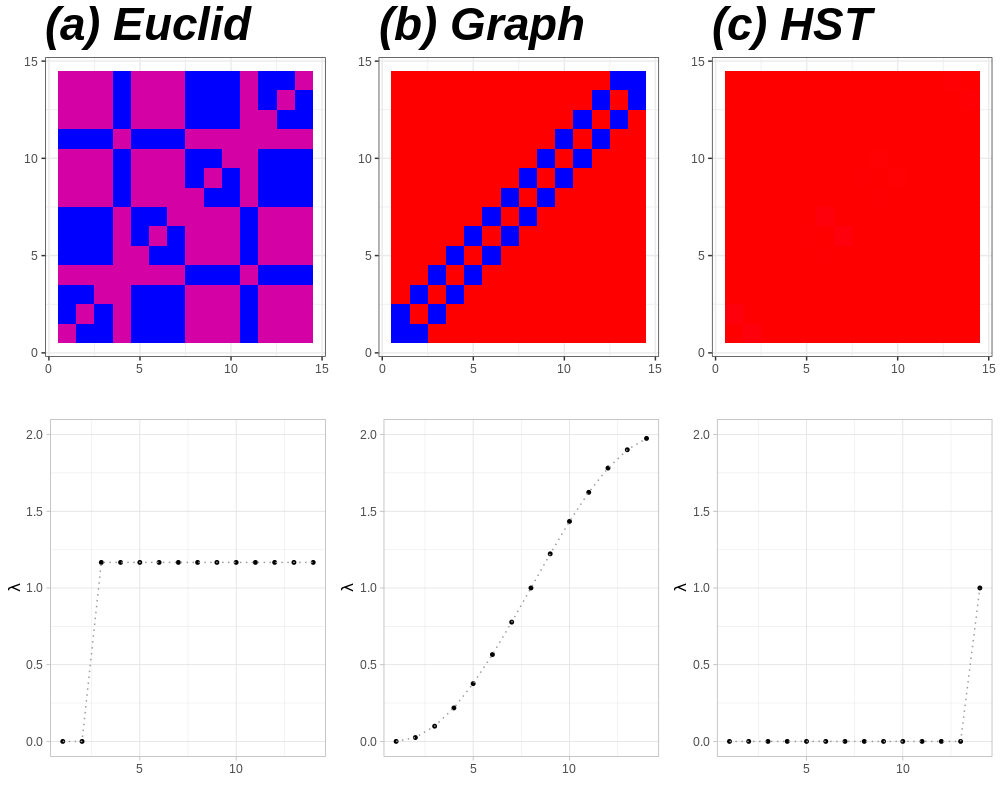

In [12]:
%%R -w 1000 -h 800 -r 100
library(gridExtra)

fig1_1<-ggplot()+geom_tile(data=W_Euclid_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="red",high="blue",mid="purple",midpoint=0.25,breaks=c(0,0.5,0.99))+
labs(fill=TeX('$W$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(a) Euclid")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_2<-ggplot()+geom_tile(data=W_Graph_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="red",high="blue",mid="purple",midpoint=0.5,breaks=c(0,0.5,0.99))+
labs(fill=TeX('$\\hat{W}$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(b) Graph")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_3<-ggplot()+geom_tile(data=W_HST_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="red",high="blue",mid="purple",midpoint=0.5,breaks=c(0,0.5,0.99))+
labs(fill=TeX('$\\hat{W}(\\tau)$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(c) HST")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_4<-eigenplot(gfftrslt_Euclid)+ylim(0,2)+theme_light()
fig1_5<-eigenplot(gfftrslt_Graph)+ylim(0,2)+theme_light()
fig1_6<-eigenplot(gfftrslt_HST)+ylim(0,2)+theme_light()
fig1=grid.arrange(fig1_1,fig1_2,fig1_3,fig1_4,fig1_5,fig1_6,ncol=3,nrow=2)
fig1
#ggsave(plot=grid.arrange(p1_a,p1_b,p1_c,ncol=3),"2021-07-22_fig1.png",width=20,height=4)

### R을 활용한 시각화 (3): Decomposition 

`-` 디콤포지션을 수행하고 결과를 저장: $(\bf{f},\bf{W})$에 decomposition을 수행하고 그 결과를 각각 `decomprslt_Euclid`, `decomprslt_Graph`, `decomprslt_HST`에 저장한다. 

In [13]:
%%R 
decomprslt_Euclid<-decompose(f,W_Euclid,V=1:n) # 0, 35000, 60000, 80000
decomprslt_Graph<-decompose(f,W_Graph,V=1:n) # 0, 35000, 60000, 80000
decomprslt_HST<-decompose(f,W_HST,V=1:n) # 0, 35000, 60000, 80000

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(n)` instead of `n` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


`-` 디콤포지션 결과는 아래와 같은 형태임 

In [14]:
%%R
head(decomprslt_Euclid)

# A tibble: 6 × 5
      V Vindex eigenvectorindex      fhat eigenvalue
  <int>  <int>            <dbl>     <dbl>      <dbl>
1     1      1                1  1.45e-32   3.28e-18
2     2      2                1  2.48e-17   3.28e-18
3     3      3                1 -2.02e-16   3.28e-18
4     4      4                1  1   e+ 0   3.28e-18
5     5      5                1  8.73e-17   3.28e-18
6     6      6                1 -6.32e-17   3.28e-18


In [15]:
%%R 
decomprslt_Euclid$method="Euclid"
decomprslt_Graph$method="Graph"
decomprslt_HST$method="HST"
decomprslt<-rbind(decomprslt_Euclid,decomprslt_Graph,decomprslt_HST)

`-` 디콤포지션결과를 시각화한다. `geom_col`과 `facet_grid`를 이용. 

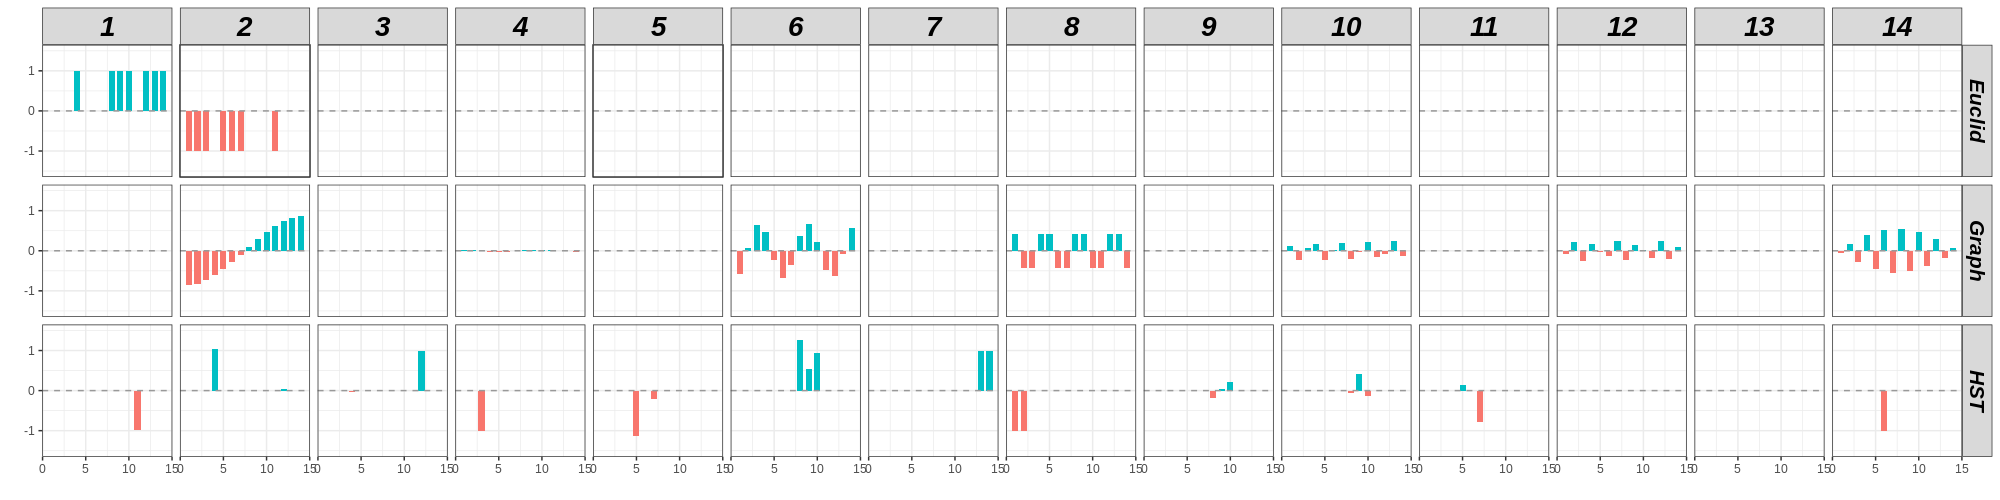

In [16]:
%%R -w 2000 -h 500 -r 100
fig2<-ggplot(data=decomprslt,aes(x=V,y=fhat))+
geom_col(aes(fill=fhat>0),width=0.7)+facet_grid(method~eigenvectorindex)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.5,1.5)+
theme(plot.title=element_text(face="bold.italic"))
fig2
#ggsave(plot=fig2,"./fig/2021-0514_fig2.pdf",width=20,height=6)